# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
# !pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from tqdm import tqdm

tqdm.pandas()

In [3]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


Добавим номера дней недели.

In [4]:
week_day = {'week_day': []}
# считаем номер недели. поле чего вычисляем записи с номеро дня. 
# определяем номер дня соответствуующий номеру последнему дню недели и после этого начинаем вычетать из него.
# номера номера дней. 
max_week_no = data['week_no'].max()
min_week_no = data['week_no'].min()

week_days=[]
for week_no in range(min_week_no,max_week_no + 1):
    max_day_in_week = data.loc[(data['week_no']==week_no),'day'].max()
    days = data.loc[(data['week_no']==week_no),'day']
    for day in days:
        week_days.append(day-max_day_in_week+7)

data['week_day'] = week_days

Заменим категориальные фитчи 'income_desc' и 'age_desc' на числовые.

In [5]:
# user_features['income_desc'].unique()
income_desc = {'35-49K':42, '50-74K':62, '25-34K':30, '75-99K':87, 'Under 15K':15, '100-124K':112,
       '15-24K':20, '125-149K':137, '150-174K':162, '250K+':250, '175-199K':187, '200-249K':225}
user_features['income_desc'] = user_features['income_desc'].apply(lambda x: income_desc[x]) 
# user_features['age_desc'].unique()
age_desc = {'65+':65, '45-54':50, '25-34':30, '35-44':40, '19-24':21, '55-64':60}	
user_features['age_desc'] = user_features['age_desc'].apply(lambda x: age_desc[x])


In [6]:
# Если я не ошибаюсь, предобработку данных на датасете 
# лучше выполнять до разделения, выборки. 
# data = prefilter_items(data, item_features=item_features, take_n_popular=5000)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,week_day
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,3
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,3


In [7]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [8]:
recommender = MainRecommender(data_train_lvl_1)

100%|██████████| 5001/5001 [00:00<00:00, 113675.34it/s]


In [9]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1037863, 951590, 1044078, 991546]

In [10]:
recommender.get_own_recommendations(2375, N=5)

[1068562, 1005935, 907099, 1112627, 1036501]

In [11]:
is_extend_with_top_popular=True
recommender.get_own_recommendations(user=2375, N=5, extend_with_top_popular=is_extend_with_top_popular)

[1068562, 1005935, 907099, 1112627, 1036501]

In [12]:
recommender.get_similar_items_recommendation(2375, N=5)

[889731, 1044078, 999207, 1062966, 9677366]

In [13]:
recommender.get_similar_users_recommendation(2375, N=5)

[1052155, 831125, 854133, 7147317, 911162]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall? 

In [14]:
data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,week_day
1748540,1602,34748855121,503,999999,2,3.98,334,0.0,843,73,0.0,0.0,2
1748542,1375,34748856592,503,849003,1,3.18,334,0.0,1708,73,0.0,0.0,7


In [15]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [16]:
# Убирем из тестовой выборки пользоватлей, которые отсутствуют в обучащей. 
# Определяем уникальных пользователей которые есть в тестовом датасете. 

result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]
result_lvl_1['user_id'].count()

2084

Для проверки работы разных вариантов рекомендаций необходимо закомментировать строчки с проверками в файле recomenders.py

```
  # assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
```


In [17]:
N=50
result_lvl_1['similar_items_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))

result_lvl_1['als_recmender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))

result_lvl_1['own_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

# Дополняем недостающие товары популярными.
is_extend_with_top_popular=True
result_lvl_1['own_recomender_extend'] = result_lvl_1['user_id'].apply(lambda x:
 recommender.get_own_recommendations(x, N=N, extend_with_top_popular=is_extend_with_top_popular))

In [18]:
N=50
recall_dic = {'method':[], 'recall':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    recall_dic['method'].append(column_name)
    recall_dic['recall'].append(result_lvl_1.apply(lambda x: recall_at_k(x[column_name], x['actual'],  N), axis=1).mean()) 

pd.DataFrame(recall_dic)

,method,recall
0,similar_items_recomender,0.061504
1,als_recmender,0.064782
2,own_recomender,0.086981
3,own_recomender_extend,0.113664


**Вывод.** 

Комбинация "own recommendtions" + "top-popular" позволила значительно повысить recall по сравнению с "own recommendtions".

**B)**\* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [19]:
def get_metrics(metric,values):
    metric_values = []
    is_extend_with_top_popular=True
    for k in tqdm(values):
        result_lvl_1[f'own_recomender_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender. \
        get_own_recommendations(x, N=k,extend_with_top_popular=is_extend_with_top_popular))
        metric_values.append(result_lvl_1.apply(lambda x: metric(x[f'own_recomender_{k}'],
        x['actual'],  k), axis=1).mean()) 
    return metric_values

In [20]:
values = [5, 10, 20, 50, 100, 200, 500]

recall = get_metrics(recall_at_k, values)

100%|██████████| 7/7 [00:27<00:00,  3.95s/it]


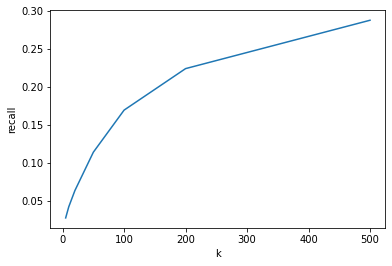

In [21]:
plt.plot(values, recall)
plt.ylabel('recall')
plt.xlabel('k')
plt.show()

**C)*** Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Для того чтобы ответить на этот вопрос, построим, дополнительно, график precision_at_k.

In [22]:
precision = get_metrics(precision_at_k, values)

100%|██████████| 7/7 [00:34<00:00,  4.87s/it]


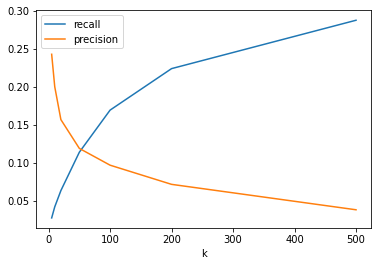

In [23]:
plt.plot(values, recall, label='recall')
plt.xlabel('k')
plt.plot(values, precision, label='precision')
plt.legend()
plt.show()

Видно, что с увеличением к-ва элементов recall  ростет, а precision уменьшается. Выбор значения k во монгом зависит от задачи, все завист от того какой параметр мы хотим максимизировать. 
Но, в общем случаем оптимальне значение k находится в месте пересечения графиков precision и recall, т.е. ~ 50.

### Задание 2.

Обучите модель 2-ого уровня, при этом:  
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар  
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2  
    - Вырос ли precision@5 при использовании двухуровневой модели?  

In [24]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,week_day
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,3
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,3


In [25]:
data_gr = data.groupby('basket_id').mean()

### Заполним фитчи User-ов.

In [26]:
user_features['median_quantity'] = user_features['user_id'].apply(lambda x: 
                                data_gr.loc[(data_gr['user_id']==x),'quantity'].median())
user_features['mean_sales_value'] = user_features['user_id'].apply(lambda x: 
                                data_gr.loc[(data_gr['user_id']==x),'sales_value'].mean())

In [27]:
for i in [1,2,3,4,5,6,7]:
    data_gr[f"day_{i}"] = np.where((data_gr['week_day'] == i),1,0)

In [28]:
week_count = data['week_no'].max()

def mean_quantity_in_week(user_id):
    days = 0
    for i in [1,2,3,4,5,6,7]:
       days += data_gr.loc[(data_gr['user_id']==user_id),f'day_{i}'].sum()
    days /=week_count
    return int(np.round(days))

In [29]:
user_features['mean_quantity_in_week'] = user_features['user_id'].apply(lambda x: mean_quantity_in_week(x))

In [30]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,median_quantity,mean_sales_value,mean_quantity_in_week
0,65,A,42,Homeowner,2 Adults No Kids,2,None/Unknown,1,1.100000,2.726818,1
1,50,A,62,Homeowner,2 Adults No Kids,2,None/Unknown,7,1.181818,2.989986,1


In [31]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


### добавим фитчи item-ов

In [32]:
item_features_temp = item_features.merge(data, on='item_id', how='left')

In [33]:
# Средняя стоимость товара в категории.

item_price = item_features_temp.groupby(['item_id','commodity_desc'])['sales_value'].mean().reset_index()
item_price.columns= ['item_id','commodity_desc','sales_value']
commoditys_desc = item_price['commodity_desc'].unique()

item_price['commodity_desc_mean_sale']=np.NaN

for commodity_desc in commoditys_desc:
    mean_value = item_price.loc[(item_price['commodity_desc']==commodity_desc),'sales_value'].mean()
    item_price.loc[(item_price['commodity_desc']==commodity_desc),'commodity_desc_mean_sale'] = mean_value
# item_features_temp.loc[(item_features_temp['commodity_desc']=='NO COMMODITY DESCRIPTION'),'sales_value']
item_price.loc[(item_price['commodity_desc']=='NO COMMODITY DESCRIPTION'),'sales_value']
# item_price
item_features = item_features.merge(item_price[['item_id','commodity_desc_mean_sale']], on='item_id',how='left')

In [34]:
# К-во покупок в неделю.

quantity_count = item_features_temp.groupby(['item_id'])['quantity'].sum().reset_index()

quantity_count.columns = ['item_id','quantity']
# data.loc[(data['item_id']==25671)]
# quantity_count
quantity_in_week = item_features_temp.groupby(['item_id'])['week_no'].unique().reset_index()

quantity_in_week.columns = ['item_id','weeks']
# quantity_in_week
quantity_in_week['weeks_count'] = quantity_in_week['weeks'].apply(lambda x: len(x))
# item_feature_temp = item_feature_temp.merge(if_week, on='item_id', how='left')
quantity_in_week['sale_in_week'] = quantity_count['quantity']/quantity_in_week['weeks_count']  
# quantity_in_week
item_features = item_features.merge(quantity_in_week[['item_id','sale_in_week']], on='item_id',how='left')

In [35]:
def perpare_lvl2(data,N=50):
    users_lvl_2 = pd.DataFrame(data['user_id'].unique()) # Добавим туда еще фитчи user-ов и item-ов.
    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(data_train_lvl_1['user_id'].unique())]

    # Заполняем кандидатов, на основе предсказания модели 1-го уровня.
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
    # test_users = data
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    # Это кандидаты. (т.е. предпологаемые покупки совершенные на основе предсказаний.)
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['drop'] = 1  # фиктивная переменная

    # Создадим таблицу с реальными покупками user-ов. 
    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 

    # Объединим предпологаемые покупки с реальными, совершенными user-ами.
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    # В результате, напротив товаров, в редсказании которых мы ошиблись, 
    # будет стоять Nan. Заполним их  нулями.  
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('drop', axis=1, inplace=True)
    targets_lvl_2['target'].mean() #Угадали примерно 17% покупок.

    # Добавим к нашему датасету фичи user-ов и item-ов.
    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X_ = targets_lvl_2.drop('target', axis=1)
    y_ = targets_lvl_2[['target']]
    return X_, y_ 

In [36]:
X_train, y_train = perpare_lvl2(data_train_lvl_2)

In [37]:
X_test, y_test = perpare_lvl2(data_val_lvl_2)

In [38]:
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,commodity_desc_mean_sale,sale_in_week,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,median_quantity,mean_sales_value,mean_quantity_in_week
0,2070,834103,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,2.705525,6.744444,50.0,U,62.0,Unknown,Unknown,1,None/Unknown,1.0,2.413486,6.0
1,2070,834103,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,2.705525,6.744444,50.0,U,62.0,Unknown,Unknown,1,None/Unknown,1.0,2.413486,6.0


In [39]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')
X_test[cat_feats] = X_test[cat_feats].astype('category')

print(cat_feats)

['manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 'commodity_desc_mean_sale', 'sale_in_week', 'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'median_quantity', 'mean_sales_value', 'mean_quantity_in_week']


In [40]:
y_train.mean()

target    0.178224
dtype: float64

In [41]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=7,
                     categorical_column=cat_feats
                     )
                     
lgb.fit(X_train, y_train)

E:\anaconda3\envs\recsys_env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\envs\recsys_env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\anaconda3\envs\recsys_env\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product',
                                   'commodity_desc_mean_sale', 'sale_in_week',
                                   'age_desc', 'marital_status_code',
                                   'income_desc', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc',
                                   'kid_category_desc', 'median_quantity',
                                   'mean_sales_value',
                                   'mean_quantity_in_week'],
               max_depth=7, objective='binary')

In [42]:
train_preds = lgb.predict_proba(X_train)[:,1]

In [43]:
x_train_t = X_train.copy()
x_train_t['predict'] = train_preds
x_train_t['true'] = y_train['target'].values
result = x_train_t.sort_values('predict', ascending=False).groupby('user_id')['item_id'].unique().reset_index()

In [44]:
overall_top_purchases = x_train_t.groupby('item_id')['item_id'].count()
overall_top_purchases = overall_top_purchases.sort_values(ascending=False).index.values

In [45]:
def extend_with_top_popular(recommendations, N=5):
    """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

    if len(recommendations) < N:
        recommendations.extend(overall_top_purchases[:N])
        recommendations = recommendations[:N]

    return recommendations

In [46]:
def get_items(x_data, data, user_id, item_name,is_extend=True):
    items_list = []
    items = data.loc[(data['user_id']==user_id),'item_id'].values[0]

    for item in items:
        flag = x_data.loc[((x_data['user_id']==user_id) & (x_data['item_id']==item)),item_name].mean()
        if flag > 0.4: # порог срабатывания. 
            items_list.append(item)
    if is_extend:
        items_list = extend_with_top_popular(items_list, N=5)
    return items_list

In [47]:
item_name = 'predict'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_train_t, result, x, item_name,is_extend=True))

item_name = 'true'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_train_t, result, x, item_name,is_extend=False))

precisions=[]
for res in result.iterrows():
    predict = res[1]['predict']
    true = res[1]['true']
    precisions.append(precision_at_k(predict,true,5))

100%|██████████| 2084/2084 [01:29<00:00, 23.31it/s]


In [48]:
np.mean(precisions)

0.2547984644913628

### Проверка на тестовой выборке.

In [49]:
test_preds = lgb.predict_proba(X_test)[:,1]

In [50]:
x_test_t = X_test.copy()
x_test_t['predict'] = test_preds
x_test_t['true'] = y_test['target'].values
result = x_test_t.sort_values('predict', ascending=False).groupby('user_id')['item_id'].unique().reset_index()

In [51]:
item_name = 'predict'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_test_t, result, x, item_name,is_extend=True))

item_name = 'true'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_test_t, result, x, item_name,is_extend=False))

precisions=[]
for res in result.iterrows():
    predict = res[1]['predict']
    true = res[1]['true']
    precisions.append(precision_at_k(predict,true,5))

100%|██████████| 1968/1968 [01:23<00:00, 23.68it/s]


In [52]:
np.mean(precisions)

0.1735772357723577

# Сравним результирующее качество двухуровневой модели с качеством одноуровневой. 

In [53]:
is_extend_with_top_popular=True
k=5
result_lvl_1[f'own_recomender_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender. \
get_own_recommendations(x, N=k,extend_with_top_popular=is_extend_with_top_popular))
precission = result_lvl_1.apply(lambda x: precision_at_k(x[f'own_recomender_{k}'], x['actual'],  k), axis=1).mean()

In [54]:
precission

0.24280230326295585

**Вывод:**
Одноуровневая показала к-во выше чем двухуровневая.  

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 